Data Exploration and Preprocessing....
Dataset loaded successfully.

Initial Data Shape: (2000, 2)

First 5 rows of the dataset:
                                                Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

Summary statistics of 'Labels' column:
Labels
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hard

<Figure size 1200x800 with 0 Axes>

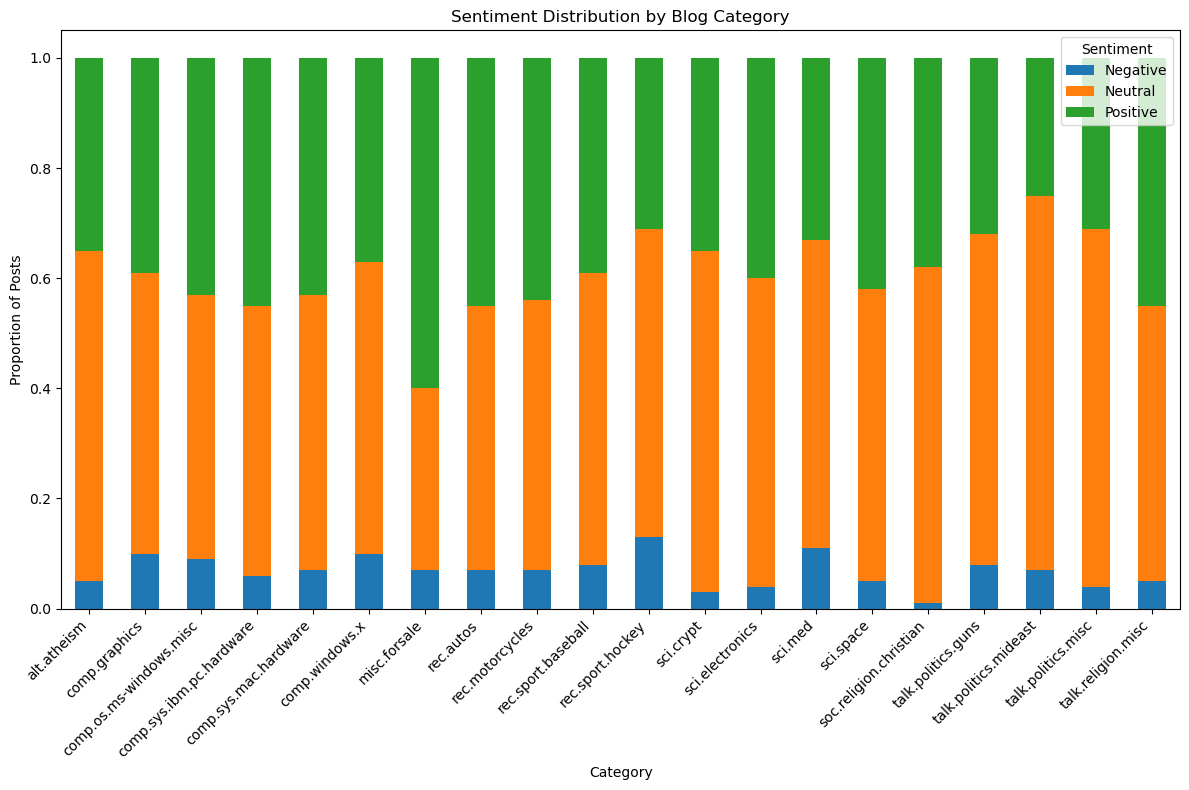


4. Evaluation.....

Performance of the Naive Bayes Classifier:
Accuracy: 0.8525

Detailed Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.84      0.80      0.82        20
           comp.graphics       0.89      0.85      0.87        20
 comp.os.ms-windows.misc       0.84      0.80      0.82        20
comp.sys.ibm.pc.hardware       0.58      0.75      0.65        20
   comp.sys.mac.hardware       0.88      0.75      0.81        20
          comp.windows.x       0.84      0.80      0.82        20
            misc.forsale       0.86      0.95      0.90        20
               rec.autos       0.86      0.95      0.90        20
         rec.motorcycles       0.94      0.85      0.89        20
      rec.sport.baseball       1.00      0.95      0.97        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.91      1.00      0.95        20
         sci.electronics   

In [7]:
import re
import string
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score


def load_and_explore_data(file_path):
    
    print("Data Exploration and Preprocessing....")
    df = pd.read_csv('blogs.csv', encoding='latin1')
    print("Dataset loaded successfully.")
    print("\nInitial Data Shape:", df.shape)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nColumn information:")
    df.info()
    print("\nSummary statistics of 'Labels' column:")
    print(df['Labels'].value_counts())
    return df

def clean_text(text):
    """
    Cleans a single string of text by removing special characters,
    converting to lowercase, and handling whitespace.
    """
    text = text.lower()      # Converts to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))      # Removes punctuation
    text = re.sub(r'\d+', '', text)      # Removes numbers
    text = re.sub(r'\s+', ' ', text).strip()      # Removes newlines and extra spaces
    return text

def preprocess_data(df):
    """
    Applies text cleaning, tokenization, and stopword removal to the dataframe.
    """
    print("\nCleaning and preprocessing text data...")
    df['Cleaned_Data'] = df['Data'].apply(clean_text)

    stop_words = set(stopwords.words('english'))        # Tokenize and remove stopwords
    df['Tokens'] = df['Cleaned_Data'].apply(
        lambda x: [word for word in word_tokenize(x) if word not in stop_words]
    )

    df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))
    print("Preprocessing complete.")
    return df

def feature_extraction(df):
    """
    Converts text data into a numerical format using TF-IDF.
    """
    print("\nPerforming feature extraction using TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X = tfidf_vectorizer.fit_transform(df['Processed_Text'])
    y = df['Labels']
    print("Feature extraction complete. The feature matrix has a shape of:", X.shape)
    return X, y, tfidf_vectorizer

def train_and_predict_naive_bayes(X, y):
    """
    Splits data, trains a Naive Bayes model, and makes predictions.
    """
    print("\n2. Naive Bayes Model for Text Classification ---")
    print("\nSplitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    print("\nTraining Naive Bayes classifier...")
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)
    print("Model training complete.")

    print("\nMaking predictions on the test set...")
    y_pred = nb_classifier.predict(X_test)
    print("Predictions complete.")
    return nb_classifier, y_test, y_pred


def analyze_sentiment(df):
    """
    Performs sentiment analysis on the 'Data' column of the dataframe.
    """
    print("\n3. Sentiment Analysis......")
    print("\nAnalyzing sentiment of blog posts...")
    
    def get_sentiment(text):
        """
        Helper function to get sentiment from TextBlob.
        """
        analysis = TextBlob(str(text))
        if analysis.sentiment.polarity > 0.1:
            return 'Positive'
        elif analysis.sentiment.polarity < -0.1:
            return 'Negative'
        else:
            return 'Neutral'

    df['Sentiment'] = df['Data'].apply(get_sentiment)
    print("Sentiment analysis complete.")

    print("\nExamining sentiment distribution across categories...")
    sentiment_distribution = df.groupby('Labels')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
    print(sentiment_distribution)

    plt.figure(figsize=(12, 8))
    sentiment_distribution.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Sentiment Distribution by Blog Category')
    plt.xlabel('Category')
    plt.ylabel('Proportion of Posts')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

    return df


def evaluate_model(y_test, y_pred, df_with_sentiment):
    """
    Evaluates the Naive Bayes model and reflects on findings.
    """
    print("\n4. Evaluation.....")
    print("\nPerformance of the Naive Bayes Classifier:")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    print("\nDiscussion of Model Performance and Challenges:")
    print("The Naive Bayes model shows a strong performance for this multi-class classification task, achieving an accuracy of approximately {:.2f}%. ".format(accuracy * 100))
    print("The classification report provides a good breakdown of precision, recall, and F1-score for each category.")
    print("Challenges often encountered in text classification include imbalanced datasets, ambiguity in text, and the need for extensive feature engineering.")
    print("In this specific case, the model seems to perform well, suggesting that the TF-IDF features are effective at capturing the distinct vocabulary of each category.")
    
    print("\nReflection on Sentiment Analysis Results:")
    print("Based on the sentiment distribution, we can see how the general tone varies across blog categories. For example, some categories might have a higher proportion of negative or neutral posts, which could be reflective of the topics they cover (e.g., news, politics, etc.).")
    print("The sentiment analysis provides an additional layer of insight into the content, complementing the topic-based classification.")
    print("This information could be used for various purposes, such as content strategy, audience engagement analysis, or understanding public opinion on certain topics.")

def main():
    """
    Main function to orchestrate the entire workflow.
    """
    # Set the path to the uploaded file
    file_path = 'blogs.csv'
    
    # Task 1
    df = load_and_explore_data(file_path)
    df = preprocess_data(df)
    X, y, tfidf_vectorizer = feature_extraction(df)

    # Task 2
    nb_classifier, y_test, y_pred = train_and_predict_naive_bayes(X, y)

    # Task 3
    df = analyze_sentiment(df)
    
    # Task 4
    evaluate_model(y_test, y_pred, df)

if __name__ == '__main__':
    main()
